In [217]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from shutil import copyfile

In [118]:
path = 'PokemonData'
newpath = 'pokemon'
os.mkdir(newpath)

classes= []

for dir_name in ['train','validation','test']: #create train validation and test folders 
    curr_path = os.path.join(newpath,dir_name)
    os.mkdir(curr_path)
    for pokemon in os.listdir(path): #create folder for each pokemon class in each folder created above
        os.mkdir(os.path.join(curr_path,pokemon))

for pokemon in os.listdir(path):
    classes.append(pokemon)
print(classes)

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

In [119]:
validation_samples = 5 
test_samples = 5
total_test = 0
total_valid = 0
total_train =  0
for pokemon in os.listdir(path): #split pokemons to train validation and test
    valid_count = 0
    test_count = 0
    source_path = os.path.join(path,pokemon)
    
    for img in os.listdir(source_path):
        image_path = os.path.join(source_path,img)
        if valid_count < validation_samples:
            dest_path = os.path.join(os.path.join(newpath,'validation'),pokemon)
            copyfile(image_path, os.path.join(dest_path,img))
            valid_count += 1
            total_valid += 1
        elif test_count < test_samples:
            dest_path = os.path.join(os.path.join(newpath,'test'),pokemon)
            copyfile(image_path, os.path.join(dest_path,img))
            test_count += 1
            total_test += 1
        else:
            dest_path = os.path.join(os.path.join(newpath,'train'),pokemon)
            copyfile(image_path, os.path.join(dest_path,img))
            total_train +=1
            
print(total_valid,total_test,total_train)

750 750 5337


In [120]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

In [121]:
train_path = 'pokemon/train'
validation_path = 'pokemon/validation'
test_path = 'pokemon/test'

In [156]:
class_names = np.array(classes)

In [157]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
IMG_SIZE = 224

In [191]:

train_batches = image_generator.flow_from_directory(directory=train_path, target_size=(IMG_SIZE,IMG_SIZE),
    classes=classes, batch_size=10,shuffle=True)
valid_batches = image_generator.flow_from_directory(directory=validation_path, target_size=(IMG_SIZE,IMG_SIZE),
    classes=classes, batch_size=5,shuffle=True)
test_batches = image_generator.flow_from_directory(directory=test_path, target_size=(IMG_SIZE,IMG_SIZE),
    classes=classes, batch_size=5,shuffle=True)

Found 5324 images belonging to 150 classes.
Found 749 images belonging to 150 classes.
Found 747 images belonging to 150 classes.


In [192]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(class_names[label_batch[n]==1][0].title())
      plt.axis('off')

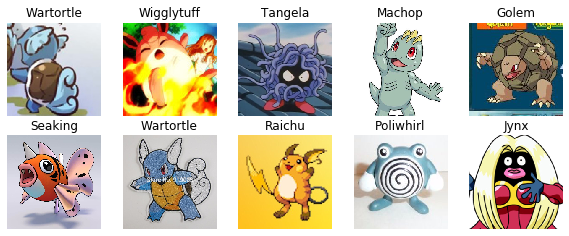

In [193]:
image_batch, label_batch = next(train_batches)
show_batch(image_batch, label_batch)

In [194]:
image_batch.shape

(10, 224, 224, 3)

In [195]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [196]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 7, 7, 1280)


In [197]:
base_model.trainable = False

In [198]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [199]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [200]:
prediction_layer = tf.keras.layers.Dense(150)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 150)


In [201]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [202]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [203]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               192150    
Total params: 2,450,134
Trainable params: 192,150
Non-trainable params: 2,257,984
_________________________________________________________________


In [204]:
initial_epochs = 3
validation_steps=1

loss0,accuracy0 = model.evaluate(valid_batches, steps = validation_steps)

1/1 [==============================] - 4s 4s/step - loss: 0.8315 - acc: 0.6600


In [206]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.66


In [207]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=valid_batches )

Epoch 1/3
533/533 [==============================] - 921s 2s/step - loss: 0.0739 - acc: 0.9899 - val_loss: 0.0470 - val_acc: 0.9933
Epoch 2/3
533/533 [==============================] - 842s 2s/step - loss: 0.0434 - acc: 0.9933 - val_loss: 0.0459 - val_acc: 0.9933
Epoch 3/3
533/533 [==============================] - 877s 2s/step - loss: 0.0403 - acc: 0.9933 - val_loss: 0.0434 - val_acc: 0.9933


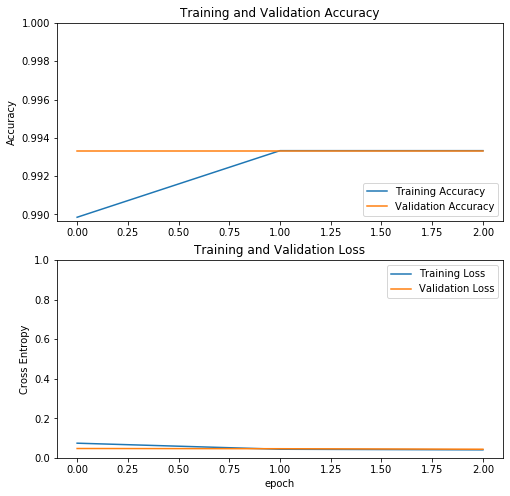

In [220]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()